In [ ]:
!pip install langgraph
!pip install langchain_groq
!pip install wikipedia
!pip install langchain
!pip install langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 638.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.0/408.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=e565788b6362ed180c674c774137cad0d65af343cbf1e032433f573558f89a2d
  Stored

In [7]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.utilities.tavily_search import TavilySearchAPIWrapper

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

from typing_extensions import TypedDict
import operator
from typing import Annotated


# LLM
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
from langchain_groq import ChatGroq

llm = ChatGroq(model = "mixtral-8x7b-32768",
        temperature = 0,
        max_tokens = 100,
        max_retries = 2,
        api_key = GROQ_API_KEY
        )

#==============AGENT==================

# Tavily API Confi.
from google.colab import userdata
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')

tavilySearchAPIWrapper = TavilySearchAPIWrapper(tavily_api_key=TAVILY_API_KEY)

# StateSchema
class State(TypedDict):
  question: str
  answer: str
  context: Annotated[list, operator.add]

def search_web(state: State):
  """ Retrieve docs from the Web Search."""
  #Search
  tavily_search = TavilySearchResults(max_results = 2,  api_wrapper=tavilySearchAPIWrapper)
  result = tavily_search.invoke(state['question'])
  formatted_docs = [
      f"Documents {doc['content']}" for doc in result
  ]

  return {"context": [formatted_docs]}

def search_wikipedia(state: State):
  """Retrieve docs from wikipedia."""

  #Search
  question = state["question"]
  search_docs = WikipediaLoader(query = question, load_max_docs=2).load()

  formatted_search = [
      f"Documents: {doc.page_content}" for doc in search_docs
  ]
  return {"context": [formatted_search]}

def generated_answer(state: State):

  """Node to answer a question."""

  # Get State:
  question = state["question"]
  context = state["context"]

  # Template
  answer_template = """Answer the question {question} using this context: {context} """
  answer_instruction = answer_template.format(question = question,
                                              context = context)

  # Answer
  answer = llm.invoke([SystemMessage(content = "You are a helpful agent.")]  + [HumanMessage(content = answer_instruction)])

  return {"answer": answer}

builder = StateGraph(State)

builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generated_answer)

builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)

memory = MemorySaver()
graph = builder.compile(checkpointer = memory)


thread = {"configurable": {"thread_id": "1"}} #Memory

print("Please Enter 'exit' to stop conversation.")
#Chat Loop
while True:
  query = input("You:: ")
  if query.lower() == 'exit':
    break
  result = graph.invoke({"question": query}, thread)
  answer = result["answer"].content
  print(f"AI: {answer}")


# An Example
#result = graph.invoke({"question": "Who is Gigori Perelman, What problem did he solved?"}, thread)
#display(Image(graph.get_graph().draw_mermaid_png())) [View the Graph]

Please Enter 'exit' to stop conversation.
You:: Who is Gigori Perelman, What problem did he solved?
AI: Grigori Perelman is a Russian mathematician who solved one of the world's most complicated math problems, the Poincare Conjecture, several years ago. The Poincare Conjecture is a problem in topology that was considered one of the most famous open problems of the 20th century. Perelman solved the problem in 2002, and it took another eight years before his peers validated his theory. Once they agreed, he
You:: exit


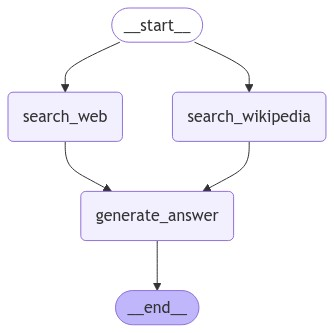

In [6]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# We can browse the state History of our agent.
# using get_state_history
all_state = [state for state in graph.get_state_history(thread)]

In [9]:
all_state

[StateSnapshot(values={'question': 'Who is Gigori Perelman, What problem did he solved?', 'answer': AIMessage(content="Grigori Perelman is a Russian mathematician who solved one of the world's most complicated math problems, the Poincare Conjecture, several years ago. The Poincare Conjecture is a problem in topology that was considered one of the most famous open problems of the 20th century. Perelman solved the problem in 2002, and it took another eight years before his peers validated his theory. Once they agreed, he", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 177, 'total_tokens': 278, 'completion_time': 0.162971864, 'prompt_time': 0.040403146, 'queue_time': 0.0008391099999999971, 'total_time': 0.20337501}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'length', 'logprobs': None}, id='run-10404db6-c548-4d49-be17-ea5355b976f8-0', usage_metadata={'input_tokens': 177, 'output_tokens':